In [1]:
import matplotlib.pyplot as plt 
import scipy.misc
import json

import numpy as np
from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization, Activation, merge, GlobalAveragePooling2D
from keras.layers.merge import Add, Multiply, Average, Maximum, Concatenate, Dot
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
from scipy.misc import imread

from keras import __version__ as kv
from scipy import __version__ as sv
from matplotlib import __version__ as mv
from numpy import __version__ as nv

print(kv)
print(sv) 
print(mv) 
print(nv) 

Using TensorFlow backend.


2.0.7
0.19.0
2.0.0
1.12.1


In [2]:
# Local files
import utils_python3
#reload(utils_python3)

# Data

### Config

In [3]:
trained_model_dir = '/home/ubuntu/data/sar/training_crops_20170829/trained_models/deployed_models/'
train_dir = '/home/ubuntu/data/sar/training_crops_20170829/train/50x50/'
valid_dir = '/home/ubuntu/data/sar/training_crops_20170829/validate/50x50/'

In [4]:
input_shape = (50, 50, 1)
num_classes = 3

### Split training_crops json into train and validate

Done in 1.0-mph_kjd_as-Python3_binary_classifier_all_data_turbine.ipynb

### Add dist2land feature and tif images

In [5]:
train_crops, train_filename, train_feature, train_class, \
valid_crops, valid_filename, valid_feature, valid_class = utils_python3.add_dist2land_training_crops_20170829_multiclass("50x50")

In [6]:
print("training crops:", len(train_crops))
print("training features:", len(train_feature))
print("validation crops:", len(valid_crops))
print("validation features:", len(valid_feature))
print(type(train_crops), type(train_crops[0]), train_crops[0].shape)

training crops: 10188
training features: 10188
validation crops: 1503
validation features: 1503
<class 'list'> <class 'numpy.ndarray'> (50, 50)


Quick check:

In [7]:
train_crops[0]

array([[ 1,  1,  2, ...,  2,  4,  5],
       [ 4,  4,  5, ...,  3,  3,  4],
       [10, 12, 13, ...,  2,  2,  2],
       ..., 
       [ 2,  3,  3, ...,  1,  1,  1],
       [ 3,  3,  2, ...,  3,  3,  4],
       [ 2,  3,  5, ...,  5,  5,  6]], dtype=uint8)

S1A_IW_GRDH_1SDV_20170526T174153_20170526T174206_016756_01BD64_55E0_terrain_correction_29.png [1, 0, 0]


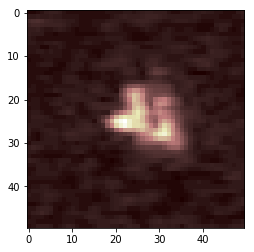

In [8]:
print(train_filename[0], train_class[0])
plt.imshow( train_crops[0], cmap='pink')
plt.show()

S1A_IW_GRDH_1SDV_20170403T062215_20170403T062240_015976_01A590_B685_terrain_correction_290.png [0, 1, 0]


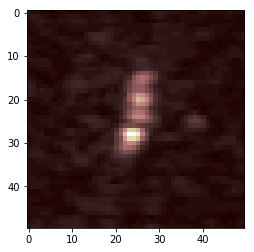

In [9]:
print(train_filename[3000], train_class[3000])
plt.imshow( train_crops[3000], cmap='pink')
plt.show()

S1A_IW_GRDH_1SDV_20170607T174104_20170607T174129_016931_01C2D4_E8F6_subset1_6.png [0, 0, 1]


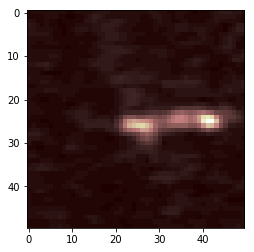

In [10]:
print(train_filename[10000], train_class[10000])
plt.imshow( train_crops[10000], cmap='pink')
plt.show()

In [11]:
# Reshape for keras format
np_train_class = np.array(train_class)
np_train_filename = np.array(train_filename)
np_train_crops = np.array(train_crops)
np_train_feature = np.array(train_feature)

np_valid_class = np.array(valid_class)
np_valid_filename = np.array(valid_filename)
np_valid_crops = np.array(valid_crops)
np_valid_feature = np.array(valid_feature)

np_train_crops = np.expand_dims(np_train_crops, axis=3)
np_train_feature = np.expand_dims(np_train_feature, axis=1)

np_valid_crops = np.expand_dims(np_valid_crops, axis=3)
np_valid_feature = np.expand_dims(np_valid_feature, axis=1)

In [12]:
print(np_train_crops.shape)
print(np_train_feature.shape)
print(np_train_class.shape)
print(np_valid_crops.shape)
print(np_valid_feature.shape)
print(np_valid_class.shape)

(10188, 50, 50, 1)
(10188, 1)
(10188, 3)
(1503, 50, 50, 1)
(1503, 1)
(1503, 3)


# Experiments

with distance

In [13]:
p = 0.5

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [14]:
model_with_distance.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 50, 50, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 50, 50, 32)    320         input_1[0][0]                    
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 25, 25, 32)    0           conv2d_1[0][0]                   
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 25, 25, 64)    18496       max_pooling2d_1[0][0]            
___________________________________________________________________________________________

In [15]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 7s - loss: 0.3035 - acc: 0.8931 - val_loss: 0.3979 - val_acc: 0.8822
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.1746 - acc: 0.9427 - val_loss: 0.2085 - val_acc: 0.9195
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.1411 - acc: 0.9541 - val_loss: 0.2233 - val_acc: 0.9162
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.1138 - acc: 0.9606 - val_loss: 0.6331 - val_acc: 0.8110
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.1012 - acc: 0.9669 - val_loss: 0.1455 - val_acc: 0.9514
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0896 - acc: 0.9703 - val_loss: 0.1482 - val_acc: 0.9594
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0714 - acc: 0.9770 - val_loss: 0.2724 - val_acc: 0.9248
Epoch 8/10
10188/10188 [==============================] - 6s -

In [16]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 6s - loss: 0.0229 - acc: 0.9924 - val_loss: 0.0826 - val_acc: 0.9794
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.0166 - acc: 0.9948 - val_loss: 0.0705 - val_acc: 0.9834
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.0120 - acc: 0.9965 - val_loss: 0.0772 - val_acc: 0.9814
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.0100 - acc: 0.9971 - val_loss: 0.0836 - val_acc: 0.9807
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.0079 - acc: 0.9975 - val_loss: 0.0861 - val_acc: 0.9814
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0070 - acc: 0.9979 - val_loss: 0.0940 - val_acc: 0.9774
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0060 - acc: 0.9981 - val_loss: 0.0880 - val_acc: 0.9800
Epoch 8/10
10188/10188 [==============================] - 6s -

In [18]:
lr = 0.00001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/3
10188/10188 [==============================] - 6s - loss: 0.0029 - acc: 0.9993 - val_loss: 0.0931 - val_acc: 0.9807
Epoch 2/3
10188/10188 [==============================] - 6s - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0916 - val_acc: 0.9794
Epoch 3/3
10188/10188 [==============================] - 6s - loss: 0.0021 - acc: 0.9996 - val_loss: 0.0947 - val_acc: 0.9794


### Dropout p = 0, Adam optimiser

In [19]:
p = 0

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_distance = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_distance.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
lr = 0.001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 7s - loss: 0.2414 - acc: 0.9113 - val_loss: 0.2038 - val_acc: 0.9301
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.1270 - acc: 0.9559 - val_loss: 0.1139 - val_acc: 0.9587
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.0964 - acc: 0.9659 - val_loss: 0.3751 - val_acc: 0.8696
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.0849 - acc: 0.9716 - val_loss: 0.1530 - val_acc: 0.9448
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.0671 - acc: 0.9773 - val_loss: 0.1388 - val_acc: 0.9514
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0587 - acc: 0.9806 - val_loss: 0.1036 - val_acc: 0.9661
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0520 - acc: 0.9826 - val_loss: 0.1304 - val_acc: 0.9587
Epoch 8/10
10188/10188 [==============================] - 6s -

In [21]:
lr = 0.0001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=5,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/5
10188/10188 [==============================] - 6s - loss: 0.0152 - acc: 0.9955 - val_loss: 0.0693 - val_acc: 0.9780
Epoch 2/5
10188/10188 [==============================] - 6s - loss: 0.0080 - acc: 0.9985 - val_loss: 0.0725 - val_acc: 0.9760
Epoch 3/5
10188/10188 [==============================] - 6s - loss: 0.0058 - acc: 0.9992 - val_loss: 0.0688 - val_acc: 0.9774
Epoch 4/5
10188/10188 [==============================] - 6s - loss: 0.0049 - acc: 0.9995 - val_loss: 0.0614 - val_acc: 0.9820
Epoch 5/5
10188/10188 [==============================] - 6s - loss: 0.0033 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9827


In [22]:
lr = 0.00001
K.set_value(model_with_distance.optimizer.lr, lr)

model_with_distance.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=5,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/5
10188/10188 [==============================] - 6s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0661 - val_acc: 0.9820
Epoch 2/5
10188/10188 [==============================] - 6s - loss: 0.0027 - acc: 1.0000 - val_loss: 0.0652 - val_acc: 0.9827
Epoch 3/5
10188/10188 [==============================] - 6s - loss: 0.0026 - acc: 0.9998 - val_loss: 0.0659 - val_acc: 0.9820
Epoch 4/5
10188/10188 [==============================] - 6s - loss: 0.0026 - acc: 1.0000 - val_loss: 0.0658 - val_acc: 0.9827
Epoch 5/5
10188/10188 [==============================] - 6s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.0651 - val_acc: 0.9820


## Dropout = 0.5, optimiser =Adam

In [23]:
p = 0.5

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_adam_dropout = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_adam_dropout.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [24]:
lr = 0.001
K.set_value(model_with_adam_dropout.optimizer.lr, lr)

model_with_adam_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 7s - loss: 0.2981 - acc: 0.8916 - val_loss: 0.3971 - val_acc: 0.8583
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.1742 - acc: 0.9397 - val_loss: 0.2490 - val_acc: 0.9148
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.1461 - acc: 0.9500 - val_loss: 0.1785 - val_acc: 0.9441
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.1225 - acc: 0.9592 - val_loss: 0.1104 - val_acc: 0.9647
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.1004 - acc: 0.9680 - val_loss: 0.1746 - val_acc: 0.9388
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0866 - acc: 0.9700 - val_loss: 0.2383 - val_acc: 0.9275
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0815 - acc: 0.9724 - val_loss: 0.3992 - val_acc: 0.8743
Epoch 8/10
10188/10188 [==============================] - 6s -

In [25]:
lr = 0.0001
K.set_value(model_with_adam_dropout.optimizer.lr, lr)

model_with_adam_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 6s - loss: 0.0365 - acc: 0.9896 - val_loss: 0.0682 - val_acc: 0.9787
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.0283 - acc: 0.9914 - val_loss: 0.0681 - val_acc: 0.9807
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.0201 - acc: 0.9943 - val_loss: 0.0711 - val_acc: 0.9794
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.0191 - acc: 0.9956 - val_loss: 0.0644 - val_acc: 0.9834
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.0159 - acc: 0.9958 - val_loss: 0.0683 - val_acc: 0.9814
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0125 - acc: 0.9968 - val_loss: 0.0585 - val_acc: 0.9860
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0116 - acc: 0.9971 - val_loss: 0.0688 - val_acc: 0.9860
Epoch 8/10
10188/10188 [==============================] - 6s -

In [26]:
lr = 0.00001
K.set_value(model_with_adam_dropout.optimizer.lr, lr)

model_with_adam_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/3
10188/10188 [==============================] - 6s - loss: 0.0059 - acc: 0.9993 - val_loss: 0.0705 - val_acc: 0.9834
Epoch 2/3
10188/10188 [==============================] - 6s - loss: 0.0055 - acc: 0.9995 - val_loss: 0.0697 - val_acc: 0.9847
Epoch 3/3
10188/10188 [==============================] - 6s - loss: 0.0053 - acc: 0.9993 - val_loss: 0.0715 - val_acc: 0.9840


## Dropout = 0.2,0.5, optimiser =Adam

In [28]:
p1 = 0.2
p2 = 0.5

classifier_input = Input(shape=input_shape)
dist2land_input = Input(shape=(1,))

x = Conv2D(32, (3, 3), activation='relu', padding='same')(classifier_input)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)

# # Following based on https://github.com/asmith26/courses/blob/master/deeplearning1/nbs/lesson7.ipynb
x = BatchNormalization(axis=-1)(x)
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Conv2D(64,(3,3), activation='relu', padding='same')(x)
x = BatchNormalization(axis=-1)(x)
x = MaxPooling2D()(x)   # REMOVED MAX POOLING FOR VISUALISATION
x = Dropout(p1)(x)
x = Conv2D(3,(3,3), padding='same')(x)
x = Dropout(p2)(x)
x = GlobalAveragePooling2D()(x)
m = Add()([dist2land_input, x])
out = Activation('softmax')(m)


model_with_adam_more_dropout = Model(inputs=[classifier_input, dist2land_input], outputs=out)
model_with_adam_more_dropout.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
lr = 0.001
K.set_value(model_with_adam_more_dropout.optimizer.lr, lr)

model_with_adam_more_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 7s - loss: 0.3302 - acc: 0.8793 - val_loss: 0.2041 - val_acc: 0.9261
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.1858 - acc: 0.9391 - val_loss: 0.1774 - val_acc: 0.9315
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.1647 - acc: 0.9462 - val_loss: 0.1623 - val_acc: 0.9474
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.1211 - acc: 0.9604 - val_loss: 0.3611 - val_acc: 0.8623
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.1112 - acc: 0.9618 - val_loss: 0.2414 - val_acc: 0.9228
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0980 - acc: 0.9666 - val_loss: 0.1478 - val_acc: 0.9448
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0909 - acc: 0.9694 - val_loss: 0.1673 - val_acc: 0.9514
Epoch 8/10
10188/10188 [==============================] - 6s -

In [30]:
lr = 0.0001
K.set_value(model_with_adam_more_dropout.optimizer.lr, lr)

model_with_adam_more_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=10,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/10
10188/10188 [==============================] - 6s - loss: 0.0405 - acc: 0.9875 - val_loss: 0.0699 - val_acc: 0.9794
Epoch 2/10
10188/10188 [==============================] - 6s - loss: 0.0273 - acc: 0.9923 - val_loss: 0.0687 - val_acc: 0.9840
Epoch 3/10
10188/10188 [==============================] - 6s - loss: 0.0255 - acc: 0.9924 - val_loss: 0.0666 - val_acc: 0.9820
Epoch 4/10
10188/10188 [==============================] - 6s - loss: 0.0216 - acc: 0.9942 - val_loss: 0.0684 - val_acc: 0.9800
Epoch 5/10
10188/10188 [==============================] - 6s - loss: 0.0174 - acc: 0.9948 - val_loss: 0.0710 - val_acc: 0.9794
Epoch 6/10
10188/10188 [==============================] - 6s - loss: 0.0158 - acc: 0.9954 - val_loss: 0.0679 - val_acc: 0.9814
Epoch 7/10
10188/10188 [==============================] - 6s - loss: 0.0150 - acc: 0.9963 - val_loss: 0.0669 - val_acc: 0.9807
Epoch 8/10
10188/10188 [==============================] - 6s -

In [31]:
lr = 0.00001
K.set_value(model_with_adam_more_dropout.optimizer.lr, lr)

model_with_adam_more_dropout.fit([np_train_crops, np_train_feature], np_train_class,
          batch_size=32,
          epochs=3,
          validation_data=([np_valid_crops, np_valid_feature], np_valid_class))

Train on 10188 samples, validate on 1503 samples
Epoch 1/3
10188/10188 [==============================] - 6s - loss: 0.0089 - acc: 0.9982 - val_loss: 0.0742 - val_acc: 0.9820
Epoch 2/3
10188/10188 [==============================] - 6s - loss: 0.0082 - acc: 0.9981 - val_loss: 0.0726 - val_acc: 0.9814
Epoch 3/3
10188/10188 [==============================] - 6s - loss: 0.0081 - acc: 0.9982 - val_loss: 0.0709 - val_acc: 0.9827


### Save model

In [32]:
model_with_adam_more_dropout.save(trained_model_dir+'/1.1-as_mph-Python3_FCN_50x50_adam_more_dropout__full-png.h5')

In [33]:
model_json = model_with_adam_more_dropout.to_json()

with open(trained_model_dir+'/1.1-as_mph-Python3_FCN_50x50_adam_more_dropout__architecture_only-png.json', 'w') as outfile:
    json.dump(model_json, outfile)

In [34]:
model_with_adam_more_dropout.save_weights(trained_model_dir+'/1.1-as_mph-Python3_FCN_50x50_adam_more_dropout__weights_only-png.h5')